X_train shape: (59, 200, 200, 3)
y_train shape: (59,)
y_train [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5]


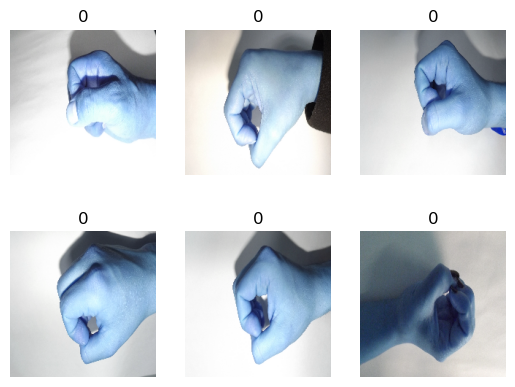

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.neighbors as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

# Define the directory containing the digit folders
data_dir = 'dataset_sample/men/'
additional_data_dir = 'dataset_sample/Women/'
# Define the image size for preprocessing
img_size = (200, 200)

# Define the label names and corresponding integer values
label_names = ['0', '1', '2', '3', '4', '5']
label_dict = {label_names[i]: i for i in range(len(label_names))}

# Initialize empty lists for the images and labels
images = []
labels = []

# Loop over the digit folders (men and women)
for data_folder in [data_dir, additional_data_dir]:
    # Loop over the label names
    for label_name in label_names:
        # Get the path to the label folder
        label_dir = os.path.join(data_folder, label_name)
        # Loop over the images in the label folder
        for file_name in os.listdir(label_dir):
            # Get the path to the image file
            file_path = os.path.join(label_dir, file_name)
            # Load the image file and preprocess it
            img = cv2.imread(file_path)
            if img is None:
                continue
            # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, img_size)
            img_normalized = img_resized / 255.0
            # Append the preprocessed image and corresponding label to the lists
            images.append(img_normalized)
            labels.append(label_dict[label_name])

# Convert the image and label lists to numpy arrays
X_train = np.array(images)
y_train = np.array(labels)

sorted_indices = np.argsort(y_train)
X_train = X_train[sorted_indices]
y_train=np.asarray(sorted(y_train))

# Print the shape of the training data
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('y_train', y_train)

# Display the images
for i in range(0, 6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(label_names[y_train[i]])
    plt.axis('off')


In [4]:
def remove_shadows(image):
    # convert to LAB color space
    # print('image', image.dtype)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        

    # split the LAB channels
    l, a, b = cv2.split(lab)
    
    # apply the Retinex algorithm to the L channel
    # set the gain to 128 for best results
    l = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3)).apply(l)
    # merge the LAB channels back together
    lab = cv2.merge((l,a,b))

    # convert back to BGR color space
    result = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return result

In [5]:
X_train_processed = []
for i in range(len(X_train)):
    img = X_train[i]
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U) # convert to 8-bit
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = remove_shadows(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) # perform morphological closing operation
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # apply threshold
   
    X_train_processed.append(img)
X_train_processed = np.array(X_train_processed)

In [6]:
X_train_processed = []
# Define the lower and upper skin color bounds in YCrCb color space
light_skin = np.array([7, 50, 50],np.uint8)
dark_skin = np.array([15, 255, 255],np.uint8)
for i in range(len(X_train)):
    
    img = X_train[i]
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U) # convert to 8-bit

    blur_img = cv2.GaussianBlur(img,(5,5),0)
    denoised_img = cv2.fastNlMeansDenoisingColored(blur_img,None,3,3,7,21)
    

    hsv_img = cv2.cvtColor(denoised_img,cv2.COLOR_BGR2HSV)
    # hsv_img = cv2.cvtColor(bgr_img,cv2.COLOR_BGR2HSV)

    frame_threshed = cv2.inRange(hsv_img, light_skin, dark_skin)
    # denoised_img = cv2.fastNlMeansDenoising(frame_threshed,None,3,7,21)
    
    X_train_processed.append(frame_threshed)
X_train_processed = np.array(X_train_processed)

# Print the shape of the preprocessed training data
print('X_train_processed shape:', X_train_processed.shape)


X_train_processed shape: (59, 200, 200)


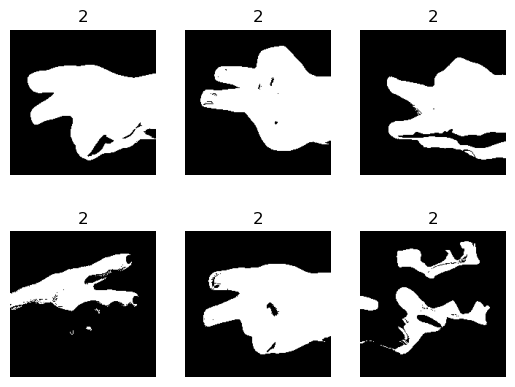

In [7]:
# Visualize the preprocessed images
#plot random 6 images from the training set

for i in range(0, 6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_train_processed[i+20], cmap='gray')
    plt.title(label_names[y_train[i+20]])
    plt.axis('off')



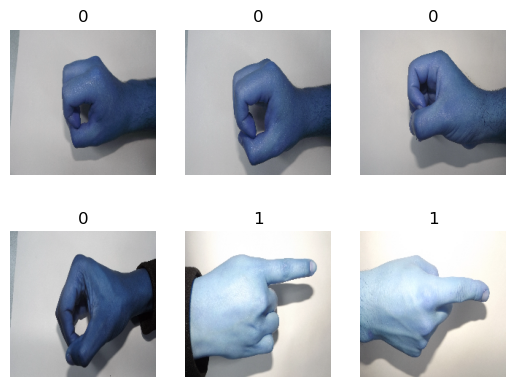

In [8]:
for i in range(0, 6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_train[i+6], cmap='gray')
    plt.title(label_names[y_train[i+6]])
    plt.axis('off')

In [19]:
# Preprocess the images to extract Hu Moments as a feature
def extract_hu_moments(grayscale_img):
    moments = cv2.moments(grayscale_img)
    hu_moments = cv2.HuMoments(moments).flatten()
    # Log-scale the Hu moments to make them more invariant to changes in scale
    log_hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
    # Return only the first two Hu moments
    return log_hu_moments[:2].flatten()
    
def extract_features(binary_img):
    height, width = binary_img.shape
    left_half_img = binary_img[:, :width//2]  # Extract the left half of the image
    right_half_img = binary_img[:, width//2:]  # Extract the right half of the image
    left_white_pixel_count = np.count_nonzero(left_half_img)
    right_white_pixel_count = np.count_nonzero(right_half_img)
    if left_white_pixel_count > right_white_pixel_count:
        return right_white_pixel_count
    else:
        return left_white_pixel_count

X_train_hu = []
for i in range(len(X_train)):
    img_gray = cv2.cvtColor((X_train[i] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    hu_moments = extract_hu_moments(img_gray)
    X_train_hu.append(hu_moments)

training_features=np.zeros((X_train_processed.shape[0],1))

for i in range(training_features.shape[0]):
    training_features[i]=extract_features(X_train_processed[i])


X_train_hu = np.array(X_train_hu)

# Combine the original feature (pixel intensity) with the Hu Moments feature
training_features = np.concatenate((training_features.reshape(-1, 1), X_train_hu), axis=1)

# Print the shape of the combined feature matrix
print('X_train_combined shape:', training_features.shape)


X_train_combined shape: (59, 3)


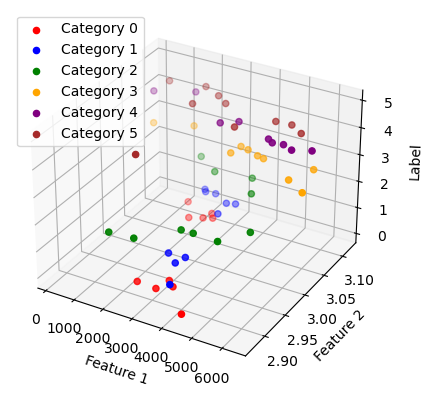

In [21]:
# Create an array of indices for each category
indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]
indices_2 = np.where(y_train == 2)[0]
indices_3 = np.where(y_train == 3)[0]
indices_4 = np.where(y_train == 4)[0]
indices_5 = np.where(y_train == 5)[0]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the features
ax.scatter(training_features[indices_0, 0], training_features[indices_0, 1], y_train[indices_0], color='red', label='Category 0')
ax.scatter(training_features[indices_1, 0], training_features[indices_1, 1], y_train[indices_1], color='blue', label='Category 1')
ax.scatter(training_features[indices_2, 0], training_features[indices_2, 1], y_train[indices_2], color='green', label='Category 2')
ax.scatter(training_features[indices_3, 0], training_features[indices_3, 1], y_train[indices_3], color='orange', label='Category 3')
ax.scatter(training_features[indices_4, 0], training_features[indices_4, 1], y_train[indices_4], color='purple', label='Category 4')
ax.scatter(training_features[indices_5, 0], training_features[indices_5, 1], y_train[indices_5], color='brown', label='Category 5')

# Set labels for the axes
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Label')

# Show legend
ax.legend()

# Show the plot
plt.show()


In [188]:
x_fit, x_test, y_fit, y_test = train_test_split(training_features, y_train, test_size=0.2, shuffle=True, stratify=labels)


# # clf = svm.SVC()


# clf.fit(x_fit,y_fit)
# y_predict = clf.predict(x_test)

# score = accuracy_score(y_predict, y_test)

# print('Accuracy: {} % '. format(score * 100))


from sklearn.neighbors import KNeighborsClassifier

# # ...

# Create an instance of the kNN classifier
clf = KNeighborsClassifier()

clf.fit(x_fit, y_fit)
y_predict = clf.predict(x_test)

score = accuracy_score(y_predict, y_test)

print('Accuracy: {} %'.format(score * 100))



Accuracy: 33.33333333333333 %


c:\Users\Omar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
